In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hs
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import glob
from stem_lstm import align_spectrum, scale_spectrum, LSTM_format

# For Keras LSTM model
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping
from keras.models import load_model
from tqdm.keras import TqdmCallback

In [2]:
# Load signals from files in the path with specified dwell time
path = '../data/dwell_time0.4s'
signals = []

for file in glob.glob(path+'/*'):
    signals.append(hs.load(file))
    
# Print array sizes, beam energy, and dwell time
for s in signals:
    print('shape:',s[2].data.shape)
    print('beam energy:',s[2].metadata.Acquisition_instrument.TEM.beam_energy)
    print('dwell time:',s[2].metadata.Acquisition_instrument.TEM.Detector.EELS.dwell_time,'\n')

shape: (120, 2048)
beam energy: 300.0
dwell time: 0.4 

shape: (160, 2048)
beam energy: 300.0
dwell time: 0.4 

shape: (160, 2048)
beam energy: 300.0
dwell time: 0.4 



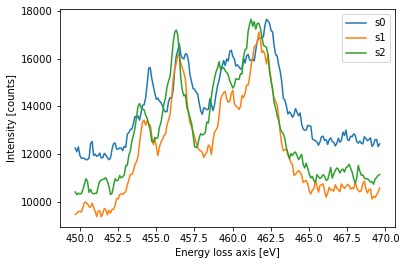

In [4]:
# Assign EELS spectrum to s variable
s0 = signals[0][2]
s1 = signals[1][2]
s2 = signals[2][2]

# Align spectra
s0_aligned = align_spectrum(s0)
s1_aligned = align_spectrum(s1)
s2_aligned = align_spectrum(s2)

# Extract bin size, scale, and offset for accurate plotting
scale = s0_aligned.axes_manager[1].scale
size = s0_aligned.axes_manager[1].size
offset = s0_aligned.axes_manager[1].offset

# Define energy scale
e_min = offset
e_max = offset + size * scale
e = np.linspace(e_min, e_max, size)

# Plot newly aligned spectra
start = 150
end = 350
timestep = 0
plt.plot(e[start:end],s0_aligned.data[timestep][start:end],label='s0')
plt.plot(e[start:end],s1_aligned.data[timestep][start:end],label='s1')
plt.plot(e[start:end],s2_aligned.data[timestep][start:end],label='s2')
plt.xlabel('Energy loss axis [eV]')
plt.ylabel('Intensity [counts]')
plt.legend();

In [5]:
# Scale the input signals
s0_scaled, scaler = scale_spectrum(s0_aligned,return_scaler = True)
s1_scaled = scaler.transform(s1_aligned)
s2_scaled = scaler.transform(s2_aligned)

In [6]:
# LSTM model hyperparameters
layers = 2
units = 256
rate = 0.05
batch_size = 50
learning_rate = 0.00001 

window_back = 8
window_forward = 8

In [7]:
# Format singals into input sequences and output spectra
X0, y0 = LSTM_format(s0_scaled, window_back, window_forward)
X1, y1 = LSTM_format(s1_scaled, window_back, window_forward)
X2, y2 = LSTM_format(s2_scaled, window_back, window_forward)

X = np.concatenate([X0,X1,X2])
y = np.concatenate([y0,y1,y2])

# Train/test split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, shuffle = True)

In [8]:
# Keras LSTM model
model = Sequential()

if layers == 1:
    model.add(LSTM(units=units, input_shape=(Xtrain.shape[1],Xtrain.shape[2])))
    model.add(Dropout(rate=rate))
else:
    # First layer specifies input_shape and returns sequences
    model.add(LSTM(units=units, return_sequences=True, input_shape=(Xtrain.shape[1],Xtrain.shape[2])))
    model.add(Dropout(rate=rate))
    # Middle layers return sequences
    for i in range(layers-2):
        model.add(LSTM(units=units,return_sequences=True))
        model.add(Dropout(rate=rate))
    # Last layer doesn't return anything
    model.add(LSTM(units=units))
    model.add(Dropout(rate=rate))

# Add Dense layer for output predictions
model.add(Dense(ytrain.shape[1]))

# Specify optimizer learning rate
opt = Adam(learning_rate=learning_rate)

# Compile model with MSE as loss mectri
model.compile(optimizer=opt, loss='mean_squared_error')

# Allow for early stopping to avoid overfitting
es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=150)

# Train the model
result = model.fit(Xtrain, ytrain, verbose=0, validation_split=0.1,
                   batch_size=batch_size,
                   epochs=3000,
                   callbacks=[es,TqdmCallback(verbose=1)]
                  )

Epoch 02650: early stopping



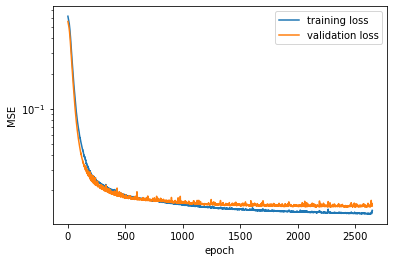

In [9]:
#### Results ####
epochs = es.stopped_epoch

# Plot epochs and loss
plt.semilogy(result.history['loss'], label='training loss')
plt.semilogy(result.history['val_loss'], label='validation loss')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.legend()

# Save model
model.save('LSTM_0.4s.h5')

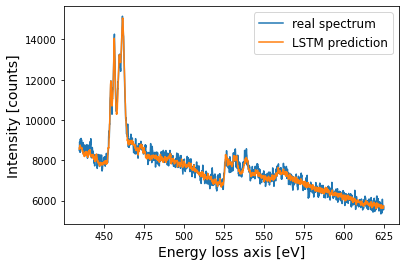

216.11096575991323


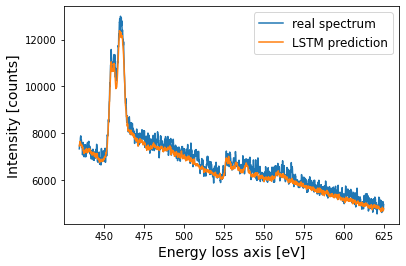

246.49072451310656


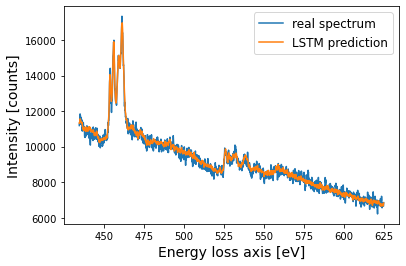

218.93030049602362


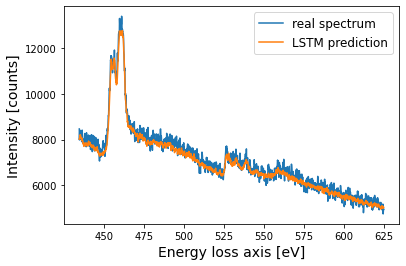

229.01861853932178


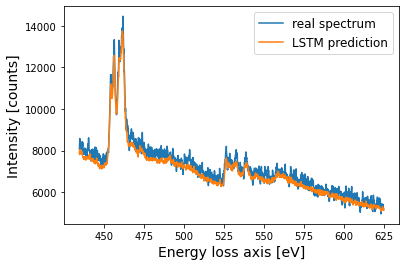

305.58423780918594


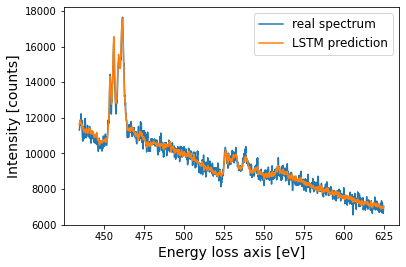

233.83983974366137


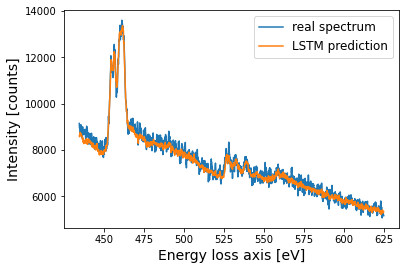

207.93742168712532


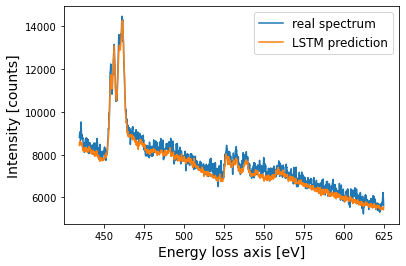

275.73178495237477
Prediction MSE: 214.19741462711022 ± 24.235560457941716


In [10]:
# Predict on test set
yp_scaled = model.predict(Xtest)
yp = scaler.inverse_transform(yp_scaled)
y_test = scaler.inverse_transform(ytest)

# Plot start and end
start, end =0,-1 # 800-1300 for O edge, 150-350 for Ti edge

# storing prediction MSE and MSE calculated based on using the last input point as the prediction
mse = []

for point_to_predict in range(0,len(y_test)):
    input_seq = Xtest[point_to_predict]
    input_seq = np.reshape(input_seq,[1,input_seq.shape[0],input_seq.shape[1]])
    
    prediction_s = model.predict(input_seq)
    prediction = scaler.inverse_transform(prediction_s)[0]
    
    # Calculate and store MSEs
    mse.append(mean_squared_error(prediction,y_test[point_to_predict])**0.5)
    
    # plot
    if point_to_predict % 10 == 0:
#         plt.figure(figsize=(12,4))
        plt.plot(e[start:end],y_test[point_to_predict][start:end],label='real spectrum')
        plt.plot(e[start:end],prediction[start:end],label='LSTM prediction')
        plt.legend(fontsize=12)
        plt.xlabel('Energy loss axis [eV]',size=14)
        plt.ylabel('Intensity [counts]',size=14)
        plt.show()
        print(mean_squared_error(prediction,y_test[point_to_predict])**0.5)
        
print('Prediction MSE:',np.mean(mse),u'\u00B1',np.std(mse))


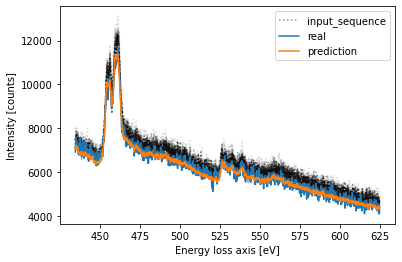

In [11]:
# Plot input sequence, real, and prediction
for i, input_spec in enumerate(Xtest[point_to_predict]):
    input_spec_us = scaler.inverse_transform(input_spec.reshape(1,-1))
    if i == 4:
        plt.plot(e,input_spec_us[0],':',color='black',alpha = (i+2)/15,label='input_sequence')
    else:
        plt.plot(e,input_spec_us[0],':',color='black',alpha = (i+2)/15)
plt.plot(e,y_test[point_to_predict],label='real')
plt.plot(e,prediction,label='prediction')
plt.legend()
plt.xlabel('Energy loss axis [eV]')
plt.ylabel('Intensity [counts]')
plt.show()